In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transaction_ori = pd.read_csv("ieee-fraud-detection/train_transaction.csv")
identity_ori = pd.read_csv("ieee-fraud-detection/train_identity.csv")

In [3]:
merge = transaction_ori.merge(identity_ori, on = "TransactionID", how = "left")
transaction_ori = None
identity_ori = None
merge

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
logRegressor = LogisticRegression(max_iter = 200)

In [5]:
#merge.fillna(0, inplace = True)
for c in merge.columns:
    merge[c] = merge[c].fillna(0)

In [6]:
train = merge.iloc[:350000,1:]
test = merge.iloc[350000:,1:]
merge = None

In [7]:
categorical_columns = ['ProductCD','card1', 'card2', 'card3', 'card4', 'card5', 'card6','addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'\
                      ,'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',\
                        'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31',\
                        'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

## MeanEncoding

In [8]:
list_dicts = []
train_columns = train.columns
for column in categorical_columns:
    mean_encoded_col_train = train.groupby(column)['isFraud'].mean().to_dict()  
    train[column] =  train[column].map(mean_encoded_col_train) 
    test[column] =  test[column].map(mean_encoded_col_train)    
    list_dicts.append(mean_encoded_col_train)
for c in test.columns:
    test[c] = test[c].fillna(train[c].mean())

In [9]:
x_train = train.drop(["isFraud"], axis=1)
y_train = train["isFraud"]
x_test = test.drop(["isFraud"], axis=1)
y_test = test["isFraud"]
test = None
train = None

In [10]:
params = {
    "penalty": ["none", "l2"],
    "tol": [0.5e-4, 1e-4, 1.5e-4],
    "C": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "fit_intercept": [True, False]    
}

## RandomizedSearch con LogisticRegression

In [11]:
clf = RandomizedSearchCV(estimator = logRegressor, param_distributions = params, cv = 3, \
                         scoring= "roc_auc", n_iter = 20, n_jobs = 1, random_state = 1, verbose = 100)

In [12]:
best_model = clf.fit(x_train.values, y_train.values)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3; 1/20] START C=0.8, fit_intercept=False, penalty=l2, tol=0.00015........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 1/20] END C=0.8, fit_intercept=False, penalty=l2, tol=0.00015;, score=0.607 total time=  16.0s
[CV 2/3; 1/20] START C=0.8, fit_intercept=False, penalty=l2, tol=0.00015........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 1/20] END C=0.8, fit_intercept=False, penalty=l2, tol=0.00015;, score=0.521 total time=  15.7s
[CV 3/3; 1/20] START C=0.8, fit_intercept=False, penalty=l2, tol=0.00015........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 1/20] END C=0.8, fit_intercept=False, penalty=l2, tol=0.00015;, score=0.561 total time=  15.9s
[CV 1/3; 2/20] START C=0.5, fit_intercept=False, penalty=none, tol=5e-05........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 2/20] END C=0.5, fit_intercept=False, penalty=none, tol=5e-05;, score=0.607 total time=  15.5s
[CV 2/3; 2/20] START C=0.5, fit_intercept=False, penalty=none, tol=5e-05........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 2/20] END C=0.5, fit_intercept=False, penalty=none, tol=5e-05;, score=0.520 total time=  14.8s
[CV 3/3; 2/20] START C=0.5, fit_intercept=False, penalty=none, tol=5e-05........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 2/20] END C=0.5, fit_intercept=False, penalty=none, tol=5e-05;, score=0.563 total time=  15.0s
[CV 1/3; 3/20] START C=0.5, fit_intercept=False, penalty=l2, tol=0.00015........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 3/20] END C=0.5, fit_intercept=False, penalty=l2, tol=0.00015;, score=0.625 total time=  15.7s
[CV 2/3; 3/20] START C=0.5, fit_intercept=False, penalty=l2, tol=0.00015........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 3/20] END C=0.5, fit_intercept=False, penalty=l2, tol=0.00015;, score=0.519 total time=  16.7s
[CV 3/3; 3/20] START C=0.5, fit_intercept=False, penalty=l2, tol=0.00015........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 3/20] END C=0.5, fit_intercept=False, penalty=l2, tol=0.00015;, score=0.569 total time=  17.5s
[CV 1/3; 4/20] START C=1, fit_intercept=False, penalty=l2, tol=5e-05............


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 4/20] END C=1, fit_intercept=False, penalty=l2, tol=5e-05;, score=0.633 total time=  16.4s
[CV 2/3; 4/20] START C=1, fit_intercept=False, penalty=l2, tol=5e-05............


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 4/20] END C=1, fit_intercept=False, penalty=l2, tol=5e-05;, score=0.518 total time=  15.4s
[CV 3/3; 4/20] START C=1, fit_intercept=False, penalty=l2, tol=5e-05............


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 4/20] END C=1, fit_intercept=False, penalty=l2, tol=5e-05;, score=0.546 total time=  14.8s
[CV 1/3; 5/20] START C=0.7, fit_intercept=True, penalty=l2, tol=0.00015.........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 5/20] END C=0.7, fit_intercept=True, penalty=l2, tol=0.00015;, score=0.606 total time=  15.0s
[CV 2/3; 5/20] START C=0.7, fit_intercept=True, penalty=l2, tol=0.00015.........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 5/20] END C=0.7, fit_intercept=True, penalty=l2, tol=0.00015;, score=0.518 total time=  15.5s
[CV 3/3; 5/20] START C=0.7, fit_intercept=True, penalty=l2, tol=0.00015.........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 5/20] END C=0.7, fit_intercept=True, penalty=l2, tol=0.00015;, score=0.563 total time=  16.5s
[CV 1/3; 6/20] START C=0.4, fit_intercept=False, penalty=l2, tol=0.0001.........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 6/20] END C=0.4, fit_intercept=False, penalty=l2, tol=0.0001;, score=0.610 total time=  15.7s
[CV 2/3; 6/20] START C=0.4, fit_intercept=False, penalty=l2, tol=0.0001.........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 6/20] END C=0.4, fit_intercept=False, penalty=l2, tol=0.0001;, score=0.527 total time=  14.8s
[CV 3/3; 6/20] START C=0.4, fit_intercept=False, penalty=l2, tol=0.0001.........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 6/20] END C=0.4, fit_intercept=False, penalty=l2, tol=0.0001;, score=0.566 total time=  15.0s
[CV 1/3; 7/20] START C=0.3, fit_intercept=False, penalty=none, tol=0.0001.......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 7/20] END C=0.3, fit_intercept=False, penalty=none, tol=0.0001;, score=0.607 total time=  15.3s
[CV 2/3; 7/20] START C=0.3, fit_intercept=False, penalty=none, tol=0.0001.......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 7/20] END C=0.3, fit_intercept=False, penalty=none, tol=0.0001;, score=0.520 total time=  15.3s
[CV 3/3; 7/20] START C=0.3, fit_intercept=False, penalty=none, tol=0.0001.......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 7/20] END C=0.3, fit_intercept=False, penalty=none, tol=0.0001;, score=0.563 total time=  16.0s
[CV 1/3; 8/20] START C=0.7, fit_intercept=False, penalty=l2, tol=5e-05..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 8/20] END C=0.7, fit_intercept=False, penalty=l2, tol=5e-05;, score=0.628 total time=  15.9s
[CV 2/3; 8/20] START C=0.7, fit_intercept=False, penalty=l2, tol=5e-05..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 8/20] END C=0.7, fit_intercept=False, penalty=l2, tol=5e-05;, score=0.528 total time=  15.1s
[CV 3/3; 8/20] START C=0.7, fit_intercept=False, penalty=l2, tol=5e-05..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 8/20] END C=0.7, fit_intercept=False, penalty=l2, tol=5e-05;, score=0.562 total time=  16.3s
[CV 1/3; 9/20] START C=0.5, fit_intercept=True, penalty=none, tol=5e-05.........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 9/20] END C=0.5, fit_intercept=True, penalty=none, tol=5e-05;, score=0.621 total time=  17.1s
[CV 2/3; 9/20] START C=0.5, fit_intercept=True, penalty=none, tol=5e-05.........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 9/20] END C=0.5, fit_intercept=True, penalty=none, tol=5e-05;, score=0.537 total time=  15.6s
[CV 3/3; 9/20] START C=0.5, fit_intercept=True, penalty=none, tol=5e-05.........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 9/20] END C=0.5, fit_intercept=True, penalty=none, tol=5e-05;, score=0.546 total time=  16.3s
[CV 1/3; 10/20] START C=0.9, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 10/20] END C=0.9, fit_intercept=True, penalty=none, tol=0.00015;, score=0.621 total time=  16.3s
[CV 2/3; 10/20] START C=0.9, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 10/20] END C=0.9, fit_intercept=True, penalty=none, tol=0.00015;, score=0.537 total time=  16.0s
[CV 3/3; 10/20] START C=0.9, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 10/20] END C=0.9, fit_intercept=True, penalty=none, tol=0.00015;, score=0.546 total time=  17.0s
[CV 1/3; 11/20] START C=0.9, fit_intercept=True, penalty=none, tol=0.0001.......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 11/20] END C=0.9, fit_intercept=True, penalty=none, tol=0.0001;, score=0.621 total time=  17.0s
[CV 2/3; 11/20] START C=0.9, fit_intercept=True, penalty=none, tol=0.0001.......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 11/20] END C=0.9, fit_intercept=True, penalty=none, tol=0.0001;, score=0.537 total time=  16.0s
[CV 3/3; 11/20] START C=0.9, fit_intercept=True, penalty=none, tol=0.0001.......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 11/20] END C=0.9, fit_intercept=True, penalty=none, tol=0.0001;, score=0.546 total time=  15.7s
[CV 1/3; 12/20] START C=0.9, fit_intercept=True, penalty=l2, tol=5e-05..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 12/20] END C=0.9, fit_intercept=True, penalty=l2, tol=5e-05;, score=0.607 total time=  15.5s
[CV 2/3; 12/20] START C=0.9, fit_intercept=True, penalty=l2, tol=5e-05..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 12/20] END C=0.9, fit_intercept=True, penalty=l2, tol=5e-05;, score=0.525 total time=  14.3s
[CV 3/3; 12/20] START C=0.9, fit_intercept=True, penalty=l2, tol=5e-05..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 12/20] END C=0.9, fit_intercept=True, penalty=l2, tol=5e-05;, score=0.563 total time=  15.1s
[CV 1/3; 13/20] START C=0.1, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 13/20] END C=0.1, fit_intercept=True, penalty=none, tol=0.00015;, score=0.621 total time=  15.7s
[CV 2/3; 13/20] START C=0.1, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 13/20] END C=0.1, fit_intercept=True, penalty=none, tol=0.00015;, score=0.537 total time=  14.8s
[CV 3/3; 13/20] START C=0.1, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 13/20] END C=0.1, fit_intercept=True, penalty=none, tol=0.00015;, score=0.546 total time=  16.3s
[CV 1/3; 14/20] START C=0.8, fit_intercept=False, penalty=none, tol=0.00015.....


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 14/20] END C=0.8, fit_intercept=False, penalty=none, tol=0.00015;, score=0.607 total time=  16.3s
[CV 2/3; 14/20] START C=0.8, fit_intercept=False, penalty=none, tol=0.00015.....


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 14/20] END C=0.8, fit_intercept=False, penalty=none, tol=0.00015;, score=0.520 total time=  14.5s
[CV 3/3; 14/20] START C=0.8, fit_intercept=False, penalty=none, tol=0.00015.....


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 14/20] END C=0.8, fit_intercept=False, penalty=none, tol=0.00015;, score=0.563 total time=  15.5s
[CV 1/3; 15/20] START C=1, fit_intercept=True, penalty=l2, tol=0.00015..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 15/20] END C=1, fit_intercept=True, penalty=l2, tol=0.00015;, score=0.606 total time=  17.2s
[CV 2/3; 15/20] START C=1, fit_intercept=True, penalty=l2, tol=0.00015..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 15/20] END C=1, fit_intercept=True, penalty=l2, tol=0.00015;, score=0.518 total time=  16.8s
[CV 3/3; 15/20] START C=1, fit_intercept=True, penalty=l2, tol=0.00015..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 15/20] END C=1, fit_intercept=True, penalty=l2, tol=0.00015;, score=0.543 total time=  24.5s
[CV 1/3; 16/20] START C=0.5, fit_intercept=False, penalty=none, tol=0.00015.....


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 16/20] END C=0.5, fit_intercept=False, penalty=none, tol=0.00015;, score=0.607 total time=  16.8s
[CV 2/3; 16/20] START C=0.5, fit_intercept=False, penalty=none, tol=0.00015.....


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 16/20] END C=0.5, fit_intercept=False, penalty=none, tol=0.00015;, score=0.520 total time=  14.3s
[CV 3/3; 16/20] START C=0.5, fit_intercept=False, penalty=none, tol=0.00015.....


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 16/20] END C=0.5, fit_intercept=False, penalty=none, tol=0.00015;, score=0.563 total time=  14.4s
[CV 1/3; 17/20] START C=0.9, fit_intercept=False, penalty=l2, tol=0.0001........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 17/20] END C=0.9, fit_intercept=False, penalty=l2, tol=0.0001;, score=0.607 total time=  14.6s
[CV 2/3; 17/20] START C=0.9, fit_intercept=False, penalty=l2, tol=0.0001........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 17/20] END C=0.9, fit_intercept=False, penalty=l2, tol=0.0001;, score=0.516 total time=  13.8s
[CV 3/3; 17/20] START C=0.9, fit_intercept=False, penalty=l2, tol=0.0001........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 17/20] END C=0.9, fit_intercept=False, penalty=l2, tol=0.0001;, score=0.545 total time=  14.4s
[CV 1/3; 18/20] START C=0.9, fit_intercept=False, penalty=none, tol=0.0001......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 18/20] END C=0.9, fit_intercept=False, penalty=none, tol=0.0001;, score=0.607 total time=  14.9s
[CV 2/3; 18/20] START C=0.9, fit_intercept=False, penalty=none, tol=0.0001......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 18/20] END C=0.9, fit_intercept=False, penalty=none, tol=0.0001;, score=0.520 total time=  14.3s
[CV 3/3; 18/20] START C=0.9, fit_intercept=False, penalty=none, tol=0.0001......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 18/20] END C=0.9, fit_intercept=False, penalty=none, tol=0.0001;, score=0.563 total time=  14.6s
[CV 1/3; 19/20] START C=0.6, fit_intercept=False, penalty=none, tol=0.0001......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 19/20] END C=0.6, fit_intercept=False, penalty=none, tol=0.0001;, score=0.607 total time=  14.9s
[CV 2/3; 19/20] START C=0.6, fit_intercept=False, penalty=none, tol=0.0001......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 19/20] END C=0.6, fit_intercept=False, penalty=none, tol=0.0001;, score=0.520 total time=  14.3s
[CV 3/3; 19/20] START C=0.6, fit_intercept=False, penalty=none, tol=0.0001......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 19/20] END C=0.6, fit_intercept=False, penalty=none, tol=0.0001;, score=0.563 total time=  14.8s
[CV 1/3; 20/20] START C=0.6, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 20/20] END C=0.6, fit_intercept=True, penalty=none, tol=0.00015;, score=0.621 total time=  15.3s
[CV 2/3; 20/20] START C=0.6, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 20/20] END C=0.6, fit_intercept=True, penalty=none, tol=0.00015;, score=0.537 total time=  14.8s
[CV 3/3; 20/20] START C=0.6, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 20/20] END C=0.6, fit_intercept=True, penalty=none, tol=0.00015;, score=0.546 total time=  15.3s


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
best_model.best_score_

0.5725475949406648

In [14]:
best_model.best_params_

{'tol': 5e-05, 'penalty': 'l2', 'fit_intercept': False, 'C': 0.7}

### ¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el dataset para validar?)

### El mejor score obtenido de validación es 0.5949517939906654. Para obtener el dataset de validación conviene hacer un split a mano (sin shuffle) y luego aplicar encoding a este dataset por separado del encoding del dataset de train.

In [2]:
pred = best_model.predict_proba(x_test.values)

In [3]:
score = roc_auc_score(y_test, pred[:, 1])
score

0.5949517939906654

### Al predecir con este modelo para la competencia, ¿Cúal es el score obtenido? (guardar el csv con predicciones para entregarlo después)

In [5]:
test_transaction = pd.read_csv("ieee-fraud-detection/test_transaction.csv")
test_identity = pd.read_csv("ieee-fraud-detection/test_identity.csv")

In [6]:
test = test_transaction.merge(test_identity, on = "TransactionID", how = "left")
test_transaction = None
test_identity = None

In [7]:
test_ids = test.TransactionID

In [8]:
for c in test.columns:
    test[c] = test[c].fillna(0)

In [9]:
test.columns = test.columns.str.replace('id-','id_')
test = test.iloc[:,1:]
test

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,18403224,31.950,W,10409,111.0,150.0,visa,226.0,debit,170.0,...,0,0.0,0,0,0,0,0,0,0,0
1,18403263,49.000,W,4272,111.0,150.0,visa,226.0,debit,299.0,...,0,0.0,0,0,0,0,0,0,0,0
2,18403310,171.000,W,4476,574.0,150.0,visa,226.0,debit,472.0,...,0,0.0,0,0,0,0,0,0,0,0
3,18403310,284.950,W,10989,360.0,150.0,visa,166.0,debit,205.0,...,0,0.0,0,0,0,0,0,0,0,0
4,18403317,67.950,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,...,0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,34214279,94.679,C,13832,375.0,185.0,mastercard,224.0,debit,284.0,...,0,0.0,0,0,0,0,0,0,0,0
506687,34214287,12.173,C,3154,408.0,185.0,mastercard,224.0,debit,0.0,...,chrome 43.0 for android,0.0,0,0,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23
506688,34214326,49.000,W,16661,490.0,150.0,visa,226.0,debit,327.0,...,0,0.0,0,0,0,0,0,0,0,0
506689,34214337,202.000,W,16621,516.0,150.0,mastercard,224.0,debit,177.0,...,0,0.0,0,0,0,0,0,0,0,0


In [10]:
for i in range(len(list_dicts)): 
    test[categorical_columns[i]] =  test[categorical_columns[i]].map(list_dicts[i])
for c in test.columns:
    test[c] = test[c].fillna(x_train[c].mean())

In [11]:
test

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,18403224,31.950,0.020450,0.000000,0.021636,0.024846,0.032729,0.028687,0.023128,0.042772,...,0.021179,0.032699,0.032531,0.032674,0.021150,0.021150,0.021150,0.021150,0.021142,0.025390
1,18403263,49.000,0.020450,0.029197,0.021636,0.024846,0.032729,0.028687,0.023128,0.022401,...,0.021179,0.032699,0.032531,0.032674,0.021150,0.021150,0.021150,0.021150,0.021142,0.025390
2,18403310,171.000,0.020450,0.000000,0.000000,0.024846,0.032729,0.028687,0.023128,0.018692,...,0.021179,0.032699,0.032531,0.032674,0.021150,0.021150,0.021150,0.021150,0.021142,0.025390
3,18403310,284.950,0.020450,0.004680,0.010873,0.024846,0.032729,0.010019,0.023128,0.010829,...,0.021179,0.032699,0.032531,0.032674,0.021150,0.021150,0.021150,0.021150,0.021142,0.025390
4,18403317,67.950,0.020450,0.018138,0.016949,0.024846,0.035530,0.016679,0.023128,0.017706,...,0.021179,0.032699,0.032531,0.032674,0.021150,0.021150,0.021150,0.021150,0.021142,0.025390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,34214279,94.679,0.107486,0.090667,0.069614,0.118970,0.035530,0.037393,0.023128,0.040816,...,0.021179,0.032699,0.032531,0.032674,0.021150,0.021150,0.021150,0.021150,0.021142,0.025390
506687,34214287,12.173,0.107486,0.057773,0.073944,0.118970,0.035530,0.037393,0.023128,0.107431,...,0.151515,0.032699,0.032531,0.032674,0.112162,0.070614,0.072273,0.080308,0.091156,0.093264
506688,34214326,49.000,0.020450,0.007905,0.023419,0.024846,0.032729,0.028687,0.023128,0.018225,...,0.021179,0.032699,0.032531,0.032674,0.021150,0.021150,0.021150,0.021150,0.021142,0.025390
506689,34214337,202.000,0.020450,0.033863,0.000000,0.024846,0.035530,0.037393,0.023128,0.020979,...,0.021179,0.032699,0.032531,0.032674,0.021150,0.021150,0.021150,0.021150,0.021142,0.025390


In [12]:
pred = best_model.predict_proba(test.values)

In [13]:
data = {"TransactionID": test_ids,
    "isFraud": pred[:, 1]}

submission = pd.DataFrame(data)
submission

,TransactionID,isFraud
0,3663549,1.643220e-06
1,3663550,1.179983e-06
2,3663551,3.093256e-07
3,3663552,9.671137e-06
4,3663553,6.483900e-05
...,...,...
506686,4170235,6.085578e-08
506687,4170236,2.799061e-08
506688,4170237,6.848882e-08
506689,4170238,4.604423e-08


In [14]:
submission.to_csv("baseline_submission.csv", index = False)

### El score obtenido en kaggle es 0.650577

### ¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.

In [15]:
data = {"column": x_train.columns,
    "importance": best_model.best_estimator_.coef_[0]}

df = pd.DataFrame(data)
df.importance = abs(df.importance)
df = df.nlargest(10, "importance")
df

,column,importance
1,TransactionAmt,0.002595
43,D15,0.002432
38,D10,0.002094
29,D1,0.001861
30,D2,0.001829
32,D4,0.001573
39,D11,0.000938
11,dist1,0.000866
362,V310,0.000826
36,D8,0.000688


Text(0.5, 0, 'Features')

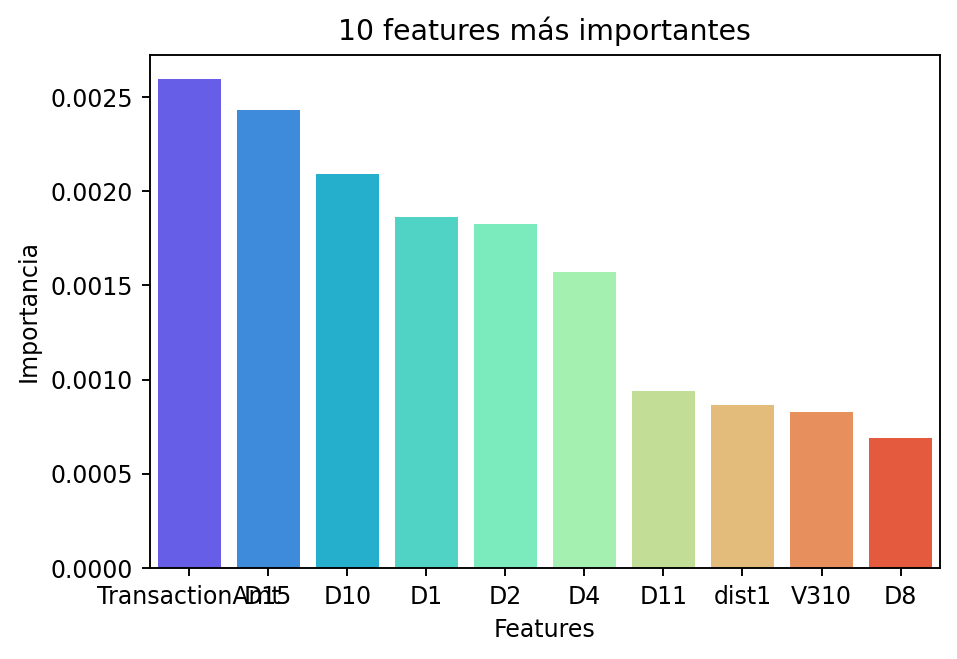

In [16]:
fig, ax = plt.subplots(dpi=170)
sns.barplot(x=df.column, y=df.importance,palette = "rainbow")
ax.set_title('10 features más importantes',fontsize=12)
ax.set_ylabel('Importancia',fontsize=10)
ax.set_xlabel('Features',fontsize=10)
#ax.set_yscale('log')